In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
#import esmlab
import utils
import pandas as pd
import numpy as np
import cmocean

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

#### Get grid

In [2]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [3]:
case ='g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [4]:
variables = ['mesozooC_zint_100m_2', 'photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint','TEMP']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [5]:
# def preprocess(ds):
#     tb=ds.time_bound
#     ds=ds.isel(z_t=0)
#     ds['time_bound'] = tb
#     return ds

In [6]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))
    
    # if var=='TEMP':
    #     ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
    #                    drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)
    #else:
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  mesozooC_zint_100m_2
starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint
starting on  TEMP


In [7]:
ds_fosi_x01["time_bound"]

<xarray.DataArray 'time_bound' (time: 768, d2: 2)>
dask.array<where, shape=(768, 2), dtype=object, chunksize=(12, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-02-01 00:00:00 ... 2022-01-01 00:00:00
Dimensions without coordinates: d2
Attributes:
    long_name:  boundaries for time-averaging interval

In [8]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [9]:
ds_fosi_x01["TEMP"] = ds_fosi_x01.TEMP.isel(z_t=0)

### Grab July of 2015

In [32]:
ds_fosi_x01["time"][686] ### MARCH!!!!!

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2015-03-16 12:00:00

In [33]:
ds_May2015 = ds_fosi_x01.isel(time=686)

### reference period 1980-2000, extract julys and then make a mean of those

In [34]:
ds_fosi_x01_may = xr.Dataset()

m=2 #index for may### MARCH!!!!!

for year in np.arange(1980,2000,1):
    
    print(year, m)
    
    ds_tmp = ds_fosi_x01.isel(time=m).drop(['time']).compute()
    
    ds_fosi_x01_may = xr.concat([ds_fosi_x01_may, ds_tmp],'time')
    
    m = m + 12

1980 2
1981 14
1982 26
1983 38
1984 50
1985 62
1986 74
1987 86
1988 98
1989 110
1990 122
1991 134
1992 146
1993 158
1994 170
1995 182
1996 194
1997 206
1998 218
1999 230


In [35]:
ds_fosi_x01_may = ds_fosi_x01_may.mean(dim='time')

### Total up NPP in July 2015 and reference July

In [36]:
ds_May2015['photoC_TOT_zint'] =  ds_May2015['photoC_cocco_zint'] + ds_May2015['photoC_diat_zint'] + ds_May2015['photoC_diaz_zint'] + ds_May2015['photoC_sp_zint']

In [37]:
ds_fosi_x01_may['photoC_TOT_zint'] =  ds_fosi_x01_may['photoC_cocco_zint'] + ds_fosi_x01_may['photoC_diat_zint'] + ds_fosi_x01_may['photoC_diaz_zint'] + ds_fosi_x01_may['photoC_sp_zint']

In [38]:
ds_May2015_anom = ds_May2015 - ds_fosi_x01_may

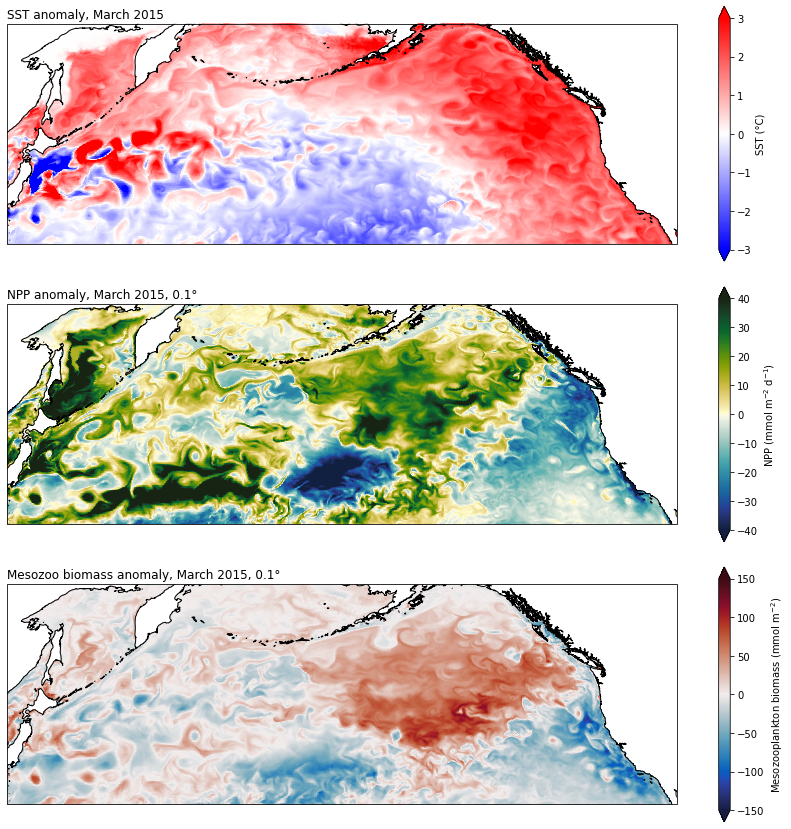

In [40]:
fig = plt.figure(figsize=(15,15))


############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('SST anomaly, March 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.TEMP)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-3,vmax=3)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='SST (°C)')
                     
############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('NPP anomaly, March 2015, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.photoC_TOT_zint*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=-40,vmax=40)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='NPP (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('Mesozoo biomass anomaly, March 2015, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.mesozooC_zint_100m_2*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,
                   vmin=-150,vmax=150)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

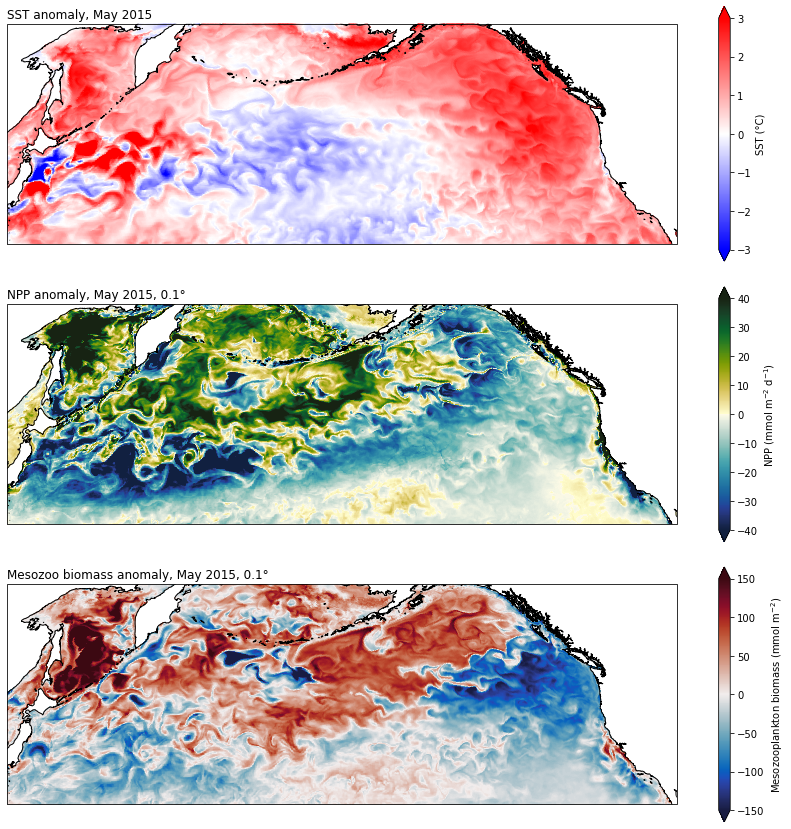

In [31]:
fig = plt.figure(figsize=(15,15))


############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('SST anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.TEMP)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-3,vmax=3)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='SST (°C)')
                     
############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('NPP anomaly, May 2015, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.photoC_TOT_zint*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=-40,vmax=40)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='NPP (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('Mesozoo biomass anomaly, May 2015, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.mesozooC_zint_100m_2*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,
                   vmin=-150,vmax=150)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

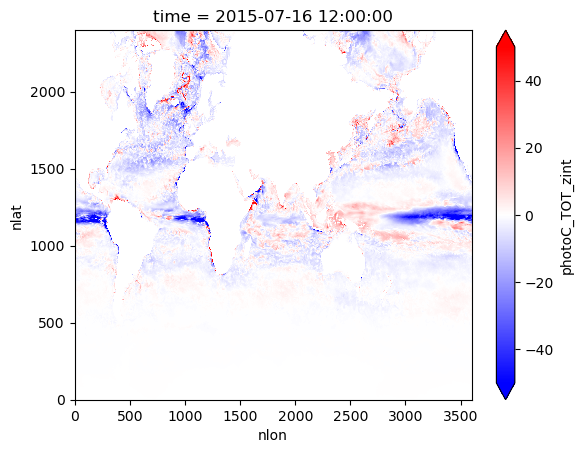

In [21]:
(ds_July2015_anom.photoC_TOT_zint*0.01*86400.).plot(vmin=-50,vmax=50,cmap='bwr')

In [4]:
ds['time'] = np.arange(1980,2022)

### Let's trim to 1990 to 2005

In [5]:
ds['time'].isel(time=slice(10,26))

<xarray.DataArray 'time' (time: 16)>
array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005])
Coordinates:
  * time     (time) int64 1990 1991 1992 1993 1994 ... 2001 2002 2003 2004 2005

In [6]:
ds = ds.isel(time=slice(10,26))

### Spin up a Dask cluster

In [ ]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='06:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [ ]:
cluster, client = get_ClusterClient()
cluster.scale(24) 

In [ ]:
client

### Input data

In [ ]:
# %%time
# ### first do 1958
# year=1980

# yr4="{:04d}".format(year)
# path = '/glade/scratch/kristenk/feisty_output/hi-res/hist/highres.' + yr4 + '.zarr'

# ds_tmp = xr.open_zarr(path, consolidated=False)

# ds = ds_tmp.mean(dim='time') #.resample({'time':'M'}).mean(dim='time').compute()

# ### then do the rest of the years

# for year in np.arange(1981,1991,1):
#     print(year)
#     yr4="{:04d}".format(year)
#     path = '/glade/scratch/kristenk/feisty_output/hi-res/hist/highres.' + yr4 + '.zarr'
    
#     ds_tmp = xr.open_zarr(path, consolidated=False)
    
#     #ds_mon = ds_tmp.resample({'time':'M'}).mean(dim='time').compute()
#     ds_tmp = ds_tmp.mean(dim='time')
#     ds = xr.concat([ds, ds_tmp], "time")

In [ ]:
ds

In [ ]:
ds_mean_fish = ds.mean(dim='time').load()

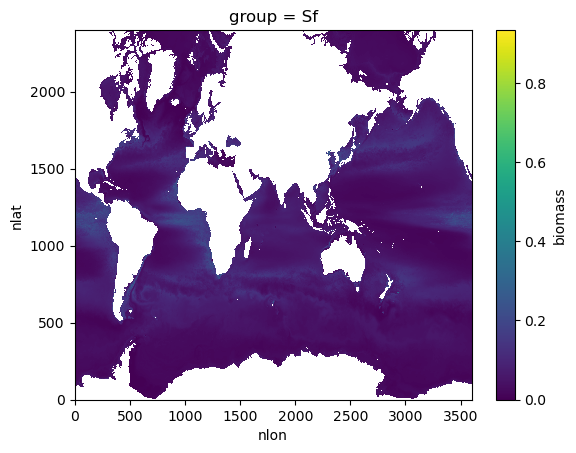

In [12]:
ds_mean_fish.biomass.sel(group='Sf').plot()

In [13]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

In [14]:
ds_mean_fish

<xarray.Dataset>
Dimensions:     (group: 9, nlat: 2400, nlon: 3600, fish: 8)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 ... 2394 2395 2396 2397 2398 2399
  * nlon        (nlon) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
Data variables:
    biomass     (group, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    fish_yield  (fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    production  (fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [15]:
tot_forage = ds_mean_fish.biomass.sel(group='Sf') + ds_mean_fish.biomass.sel(group='Mf')
tot_pelagic = ds_mean_fish.biomass.sel(group='Sp') + ds_mean_fish.biomass.sel(group='Mp') + ds_mean_fish.biomass.sel(group='Lp')
tot_demersal = ds_mean_fish.biomass.sel(group='Sd') + ds_mean_fish.biomass.sel(group='Md') + ds_mean_fish.biomass.sel(group='Ld')

tot_fish = tot_forage + tot_pelagic + tot_demersal

### Annual mean fish biomass maps

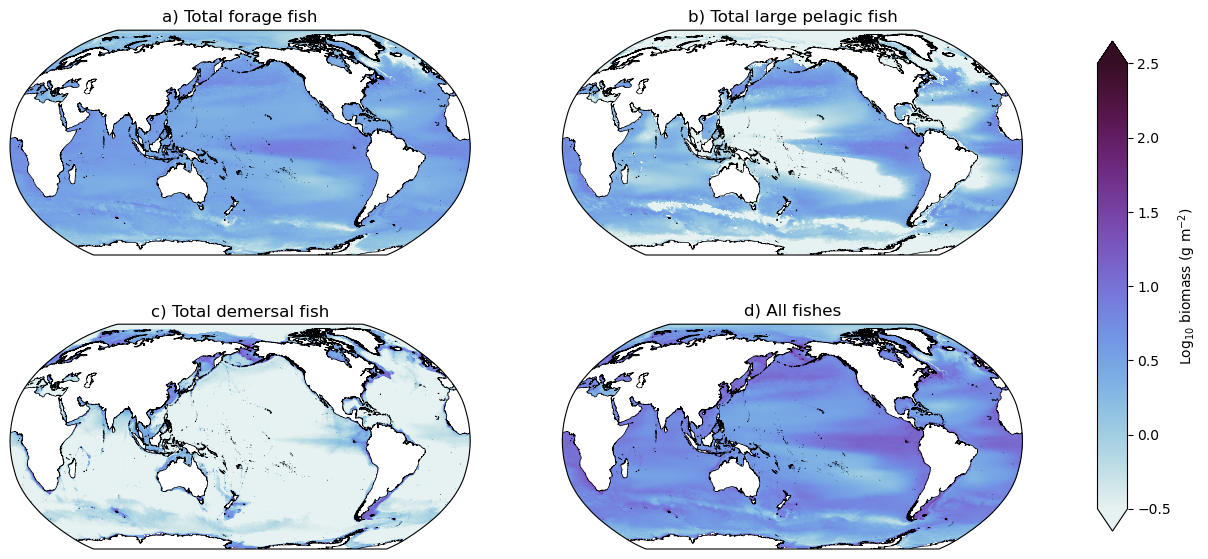

In [16]:
fig = plt.figure(figsize=(15,7))

tot_fish_group_label_dict = {'forage':
                             {'data': tot_forage,
                              'label': "a) Total forage fish"},
                             'pelagic':
                             {'data': tot_pelagic,
                              'label': "b) Total large pelagic fish"},
                             'demersal':
                             {'data': tot_demersal,
                              'label': "c) Total demersal fish"},
                             'total':
                             {'data': tot_fish,
                              'label': "d) All fishes"}
                            }

plot_index = 1

for i in tot_fish_group_label_dict.keys():
    ax = fig.add_subplot(2,2,plot_index, projection=ccrs.Robinson(central_longitude=180))
    plot_index += 1

    ax.set_title(tot_fish_group_label_dict[i]['label'], loc='center')
    lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict[i]['data'])) 

    pc=ax.pcolormesh(lon, lat, field, 
                     vmin=-0.5, vmax=2.5, 
                     cmap=cmocean.cm.dense,
                     transform=ccrs.PlateCarree())

    ax.coastlines('10m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='Log$_{10}$ biomass (g m$^{-2}$)')

fig.savefig('/glade/work/kristenk/figs/fig_fish_mean_maps_hires.png', bbox_inches='tight', dpi=300, format='png');


### Now read in phyto and zoo data, then make dominant type maps and zonal mean plots

In [17]:
ocn_vars = ['spC','diatC','diazC','coccoC','mesozooC','microzooC']
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [18]:
def preprocess(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.mean(dim=['time']).compute()
    ds = ds.sum(dim='z_t_150m').compute() #.where(ds_grid.REGION_MASK>0).compute()
    return ds

In [19]:
keep_vars = ocn_vars +['dz','KMT']

In [20]:
%%time

ds_ann_fosi = xr.Dataset()

#for year in np.arange(1997,2006,1):
for year in np.arange(1990,2006,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in ocn_vars:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    
    ## add it to the annual file
    ds_ann_fosi = xr.concat([ds_ann_fosi, ds], "time")

1990
spC
diatC
diazC
coccoC
mesozooC
microzooC
1991
spC
diatC
diazC
coccoC
mesozooC
microzooC
1992
spC
diatC
diazC
coccoC
mesozooC
microzooC
1993
spC
diatC
diazC
coccoC
mesozooC
microzooC
1994
spC
diatC
diazC
coccoC
mesozooC
microzooC
1995
spC
diatC
diazC
coccoC
mesozooC
microzooC
1996
spC
diatC
diazC
coccoC
mesozooC
microzooC
1997
spC
diatC
diazC
coccoC
mesozooC
microzooC
1998
spC
diatC
diazC
coccoC
mesozooC
microzooC
1999
spC
diatC
diazC
coccoC
mesozooC
microzooC
2000
spC
diatC
diazC
coccoC
mesozooC
microzooC
2001
spC
diatC
diazC
coccoC
mesozooC
microzooC
2002
spC
diatC
diazC
coccoC
mesozooC
microzooC
2003
spC
diatC
diazC
coccoC
mesozooC
microzooC
2004
spC
diatC
diazC
coccoC
mesozooC
microzooC
2005
spC
diatC
diazC
coccoC
mesozooC
microzooC
CPU times: user 4min 22s, sys: 6min 2s, total: 10min 25s
Wall time: 1h 14min


In [21]:
ds_ann_fosi = ds_ann_fosi.where(ds_grid.REGION_MASK>0).compute()

#### now for each variable, take times 10 to make a proper depth integral and adjust attributes

In [22]:
for var in ocn_vars:
    
    ds[var] = ds[var] * 10.
    ds[var].attrs['units'] = 'mmol/m2'

In [23]:
for var in ocn_vars:
    
    ds[var] = ds[var] * 0.001 * 12.
    ds[var].attrs['units'] = 'g/m2'

In [24]:
ds_fosi_mean = ds_ann_fosi.mean(dim='time').load()

#### calc dominant phyto

In [25]:
tot_phyto = ds_fosi_mean.spC + ds_fosi_mean.diatC + ds_fosi_mean.coccoC + ds_fosi_mean.diazC

sp_frac = ds_fosi_mean.spC/tot_phyto
diat_frac =  ds_fosi_mean.diatC/tot_phyto
cocco_frac = ds_fosi_mean.coccoC/tot_phyto
diaz_frac = ds_fosi_mean.diazC/tot_phyto

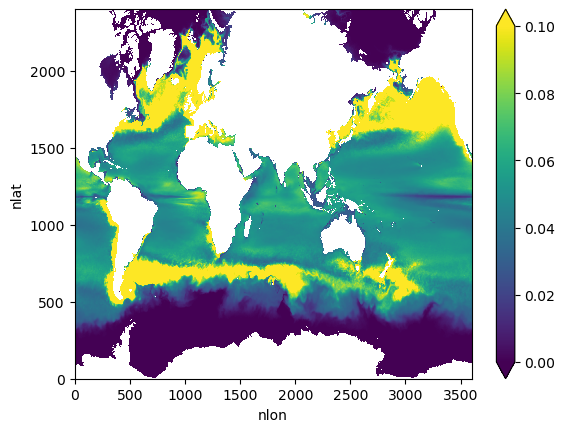

In [26]:
cocco_frac.plot(vmin=0,vmax=0.1)

In [27]:
tmp = xr.concat((sp_frac, diat_frac, cocco_frac, diaz_frac),dim='phyto')
dom_phyto = tmp.argmax(dim='phyto', skipna=False).where(ds_grid.REGION_MASK >0)

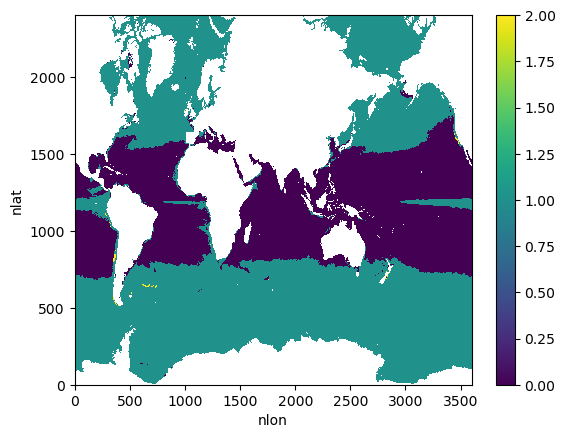

In [28]:
dom_phyto.plot()

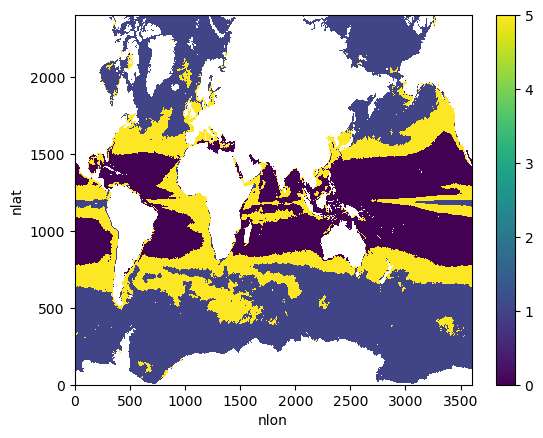

In [29]:
max_fracs = tmp.max(dim='phyto', skipna=False).where(ds_grid.REGION_MASK >0)
dom_phyto.where(max_fracs>0.6,other=5).where(ds_grid.REGION_MASK > 0).plot()

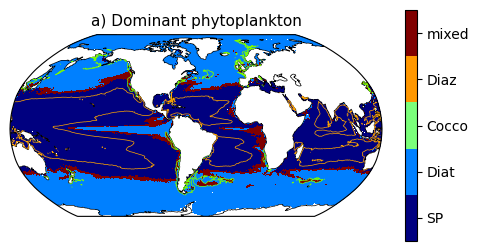

In [30]:
fig = plt.figure(figsize=(6,3))

##############

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,5,1)}
ax.set_title('a) Dominant phytoplankton', fontsize=11)

lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_phyto.where(max_fracs>0.5,other=4).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('jet',5),vmin=-0.5,vmax=4.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, cocco_frac)
cs = ax.contour(lon,lat,field, colors='lawngreen',
    levels = [0.2],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())


lon,lat,field = utils.adjust_pop_grid(lons, lats, diaz_frac)
cs = ax.contour(lon,lat,field, colors='orange',
    levels = [0.05],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['SP', 'Diat', 'Cocco', 'Diaz','mixed']);



### calc dominant zoo

In [31]:
microzoo_frac = ds_fosi_mean.microzooC/(ds_fosi_mean.microzooC + ds_fosi_mean.mesozooC)
mesozoo_frac =  ds_fosi_mean.mesozooC/(ds_fosi_mean.microzooC + ds_fosi_mean.mesozooC)

In [32]:
### combine fractions into one dimension
tmp = xr.concat((microzoo_frac, mesozoo_frac),dim='zoo')

max_fracs_zoo = tmp.max(dim='zoo', skipna=False).where(ds_grid.REGION_MASK >0)
dom_zoo = tmp.argmax(dim='zoo', skipna=False).where(ds_grid.REGION_MASK >0)

### calc dominant fish

In [33]:
forage_frac = tot_forage/tot_fish
dem_frac = tot_demersal/tot_fish
pel_frac = tot_pelagic/tot_fish
for_dem_frac = (tot_forage + tot_demersal)/tot_fish


In [34]:
pel_frac = pel_frac.drop(['group'])
# dem_frac = dem_frac.drop(['group'])
# forage_frac = forage_frac.drop(['group'])

In [35]:
### combine fractions into one dimension
tmp = xr.concat((forage_frac, dem_frac, pel_frac),dim='fish')

max_fracs_fish = tmp.max(dim='fish', skipna=False).where(ds_grid.REGION_MASK >0)
dom_fish = tmp.argmax(dim='fish', skipna=False).where(ds_grid.REGION_MASK >0)

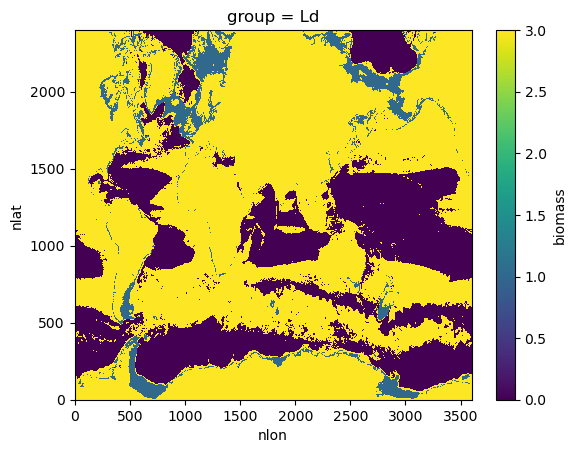

In [36]:
dom_fish.where(max_fracs_fish>0.6,other=3).plot()

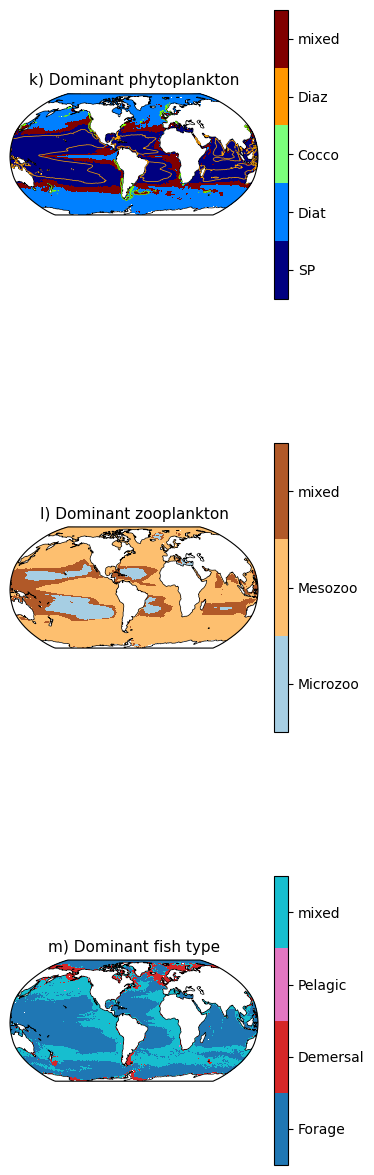

In [37]:
fig = plt.figure(figsize=(4,15))

##############
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,5,1)}
ax.set_title('k) Dominant phytoplankton', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_phyto.where(max_fracs>0.55,other=4).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('jet',5),vmin=-0.5,vmax=4.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, cocco_frac)
cs = ax.contour(lon,lat,field, colors='lawngreen',
    levels = [0.25],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())


lon,lat,field = utils.adjust_pop_grid(lons, lats, diaz_frac)
cs = ax.contour(lon,lat,field, colors='orange',
    levels = [0.05],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['SP', 'Diat', 'Cocco', 'Diaz','mixed']);

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,3,1)}
ax.set_title('l) Dominant zooplankton', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_zoo.where(max_fracs_zoo>0.55,other=2).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Paired',3),vmin=-0.5,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['Microzoo', 'Mesozoo','mixed']);

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,4,1)}
ax.set_title('m) Dominant fish type', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_fish.where(max_fracs_fish>0.55,other=3).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('tab10',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['Forage', 'Demersal','Pelagic','mixed']);


fig.subplots_adjust(wspace=0.07,hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/dominant_types.png', bbox_inches='tight', dpi=300, format='png');

In [38]:
tot_demersal

<xarray.DataArray 'biomass' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 ... 3593 3594 3595 3596 3597 3598 3599
    group    <U2 'Ld'

## Zonal means

In [39]:
ds_fosi_mean['nlat'] = ds_grid.nlat
ds_fosi_mean['nlon'] = ds_grid.nlon
area['nlat'] = ds_grid.nlat
area['nlon'] = ds_grid.nlon

In [40]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [41]:
ds_zonal_x01 = xr.Dataset()
ds_zonal_x01_sd = xr.Dataset()

for var in ocn_vars:
    
    da = np.full((57),np.nan)
    da_sd = np.full((57),np.nan)
    
    i=0
    
    for lat_band in np.arange(-78,90,3):
        
        mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
        masked_area = area.where(mask==1)   

        masked_fosi = ds_fosi_mean[var].where(mask==1)

        weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
        da[i] = weighted_mean_fosi.values
        da_sd[i] = weighted_st_dev
        #print(lat_band, weighted_mean_fosi.values)
        i = i + 1
        
    ds_zonal_x01[var] = xr.DataArray(da,dims=('lat'))
    ds_zonal_x01_sd[var] = xr.DataArray(da_sd,dims=('lat'))
        
ds_zonal_x01['lat'] = np.arange(-78,93,3)

In [42]:
ds_zonal_x01_sd['lat'] = np.arange(-78,93,3)

In [43]:
#do forage fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)

i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_forage.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
    da[i] = weighted_mean_fosi.values
    da_sd[i] = weighted_st_dev
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x01['forage_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x01_sd['forage_fish'] = xr.DataArray(da_sd,dims=('lat'))

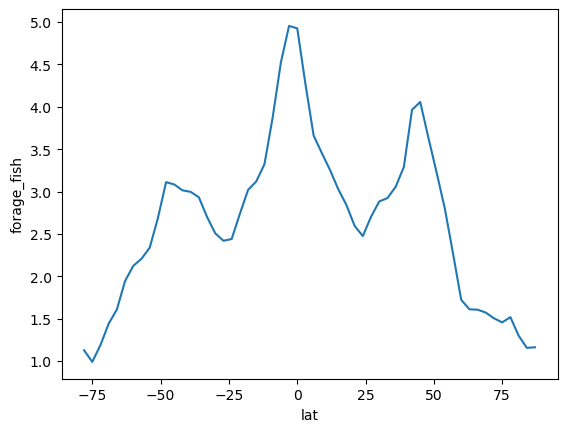

In [44]:
ds_zonal_x01['forage_fish'].plot()

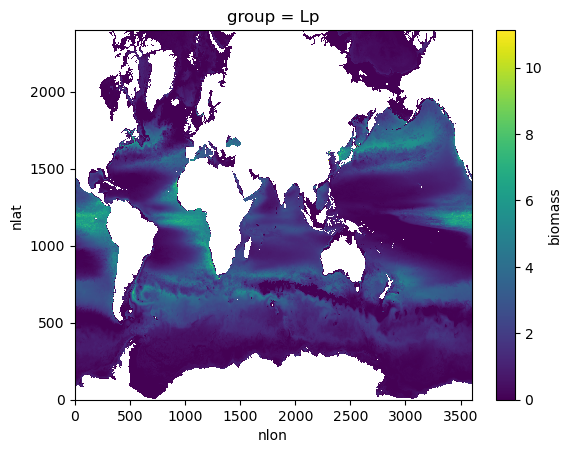

In [45]:
tot_pelagic.plot()

In [46]:
#do pelagic fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)

i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_pelagic.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    

    da[i] = weighted_mean_fosi.values
    da_sd[i] = weighted_st_dev
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x01['pelagic_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x01_sd['pelagic_fish'] = xr.DataArray(da_sd,dims=('lat'))

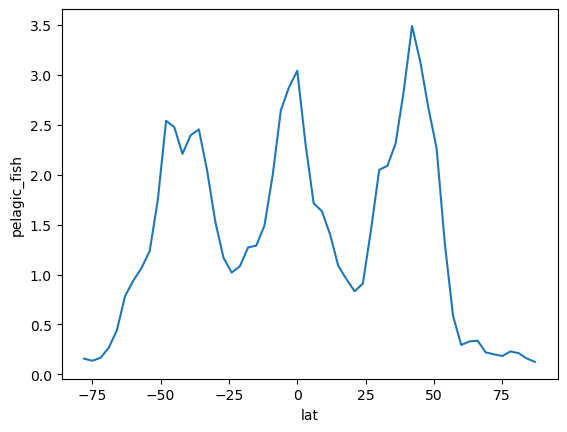

In [47]:
ds_zonal_x01['pelagic_fish'].plot()

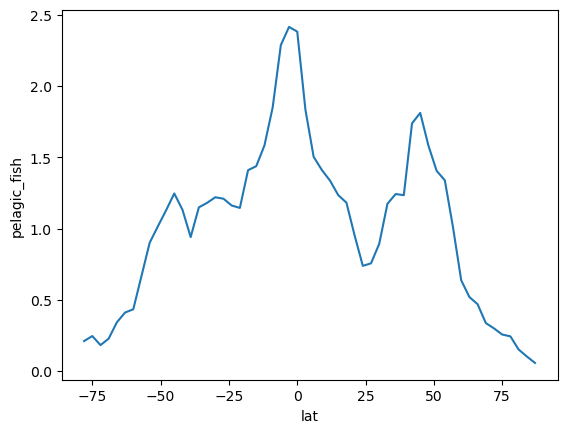

In [48]:
ds_zonal_x01_sd['pelagic_fish'].plot()

In [49]:
tot_demersal = tot_demersal.where(tot_demersal < 10000.)
tot_demersal = tot_demersal.where(tot_demersal > -100.)

In [50]:
tot_demersal.min()

<xarray.DataArray 'biomass' ()>
array(0.00377252)
Coordinates:
    group    <U2 'Ld'

In [51]:
#do demersal fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)
    
i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_demersal.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
    da[i] = weighted_mean_fosi
    da_sd[i] = weighted_st_dev                                                                            
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x01['demersal_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x01_sd['demersal_fish'] = xr.DataArray(da_sd,dims=('lat'))

In [52]:
ds_zonal_x01['demersal_fish'].values

array([3.6594107 , 1.8720539 , 0.8113785 , 1.20673851, 0.90001457,
       0.63049284, 0.49256148, 0.80980038, 1.23595252, 1.17217852,
       0.78417189, 0.76517983, 0.6619057 , 0.45264187, 0.65090198,
       0.38109797, 0.36719243, 0.40584991, 0.36867549, 0.39108342,
       0.3822746 , 0.37131905, 0.47395219, 0.58476129, 0.60886042,
       0.72811372, 0.73349479, 0.76240112, 0.76436249, 0.74047722,
       0.57863821, 0.51624157, 0.57017524, 0.5463579 , 0.51555038,
       0.64191152, 0.60215266, 0.76012828, 0.86699458, 0.92285343,
       1.39183094, 1.71405626, 1.83116653, 2.67944873, 3.73345745,
       4.59028167, 4.68019098, 5.86163751, 4.50882901, 3.76880557,
       2.50971071, 2.34456455, 1.49466063, 0.41303624, 0.06608984,
       0.04329083,        nan])

In [53]:
ds_zonal_x01_sd['demersal_fish'].values

array([3.14194761, 3.8864549 , 2.22077038, 3.35679457, 2.77480482,
       1.97534802, 0.23507507, 2.36618686, 3.30566554, 3.17751239,
       2.24430148, 2.36849962, 2.22410498, 1.86815765, 3.10918706,
       1.64500361, 1.96469576, 2.13808241, 1.73397403, 1.38360697,
       1.40142108, 1.58816322, 1.73193956, 2.11305656, 1.43716108,
       1.29412161, 1.9705519 , 1.17061999, 1.1854408 , 1.25642106,
       1.09423785, 1.09482807, 1.36852076, 1.45133137, 1.3484564 ,
       1.51545749, 1.58600084, 1.78661595, 2.27676267, 2.31199493,
       3.19099376, 3.42850853, 3.26944295, 4.5662743 , 4.49174689,
       4.80686332, 5.59547227, 6.37279551, 5.38440227, 3.00600335,
       2.27769325, 2.39885936, 2.30800976, 1.02220171, 0.06262597,
       0.02214312,        nan])

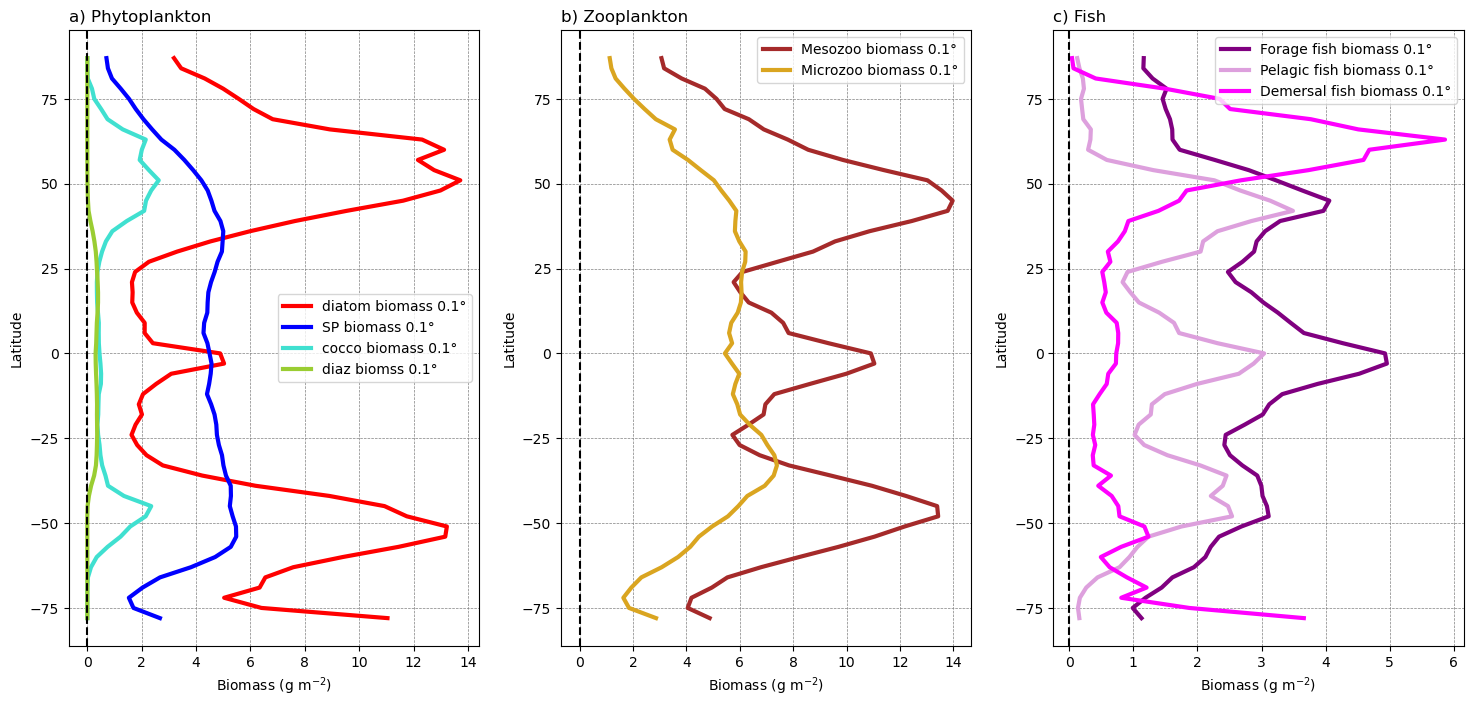

In [54]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) Phytoplankton', loc='left')
ax.plot(ds_zonal_x01.diatC, ds_zonal_x01.lat, label='diatom biomass 0.1°', linewidth=3, color='red')
ax.plot(ds_zonal_x01.spC, ds_zonal_x01.lat, label='SP biomass 0.1°', linewidth=3, color='blue')
ax.plot(ds_zonal_x01.coccoC, ds_zonal_x01.lat, label='cocco biomass 0.1°', linewidth=3, color='turquoise')
ax.plot(ds_zonal_x01.diazC, ds_zonal_x01.lat, label='diaz biomss 0.1°', linewidth=3, color='yellowgreen')

# ax.plot(ds_zonal_x1.photoC_diat_zint*0.01*86400, ds_zonal_x1.lat, label='diatom NPP x1', linewidth=1, color='red')
# ax.plot(ds_zonal_x1.photoC_sp_zint*0.01*86400, ds_zonal_x1.lat, label='SP NPP x1', linewidth=1, color='blue')
# ax.plot(ds_zonal_x1.photoC_cocco_zint*0.01*86400, ds_zonal_x1.lat, label='cocco NPP x1', linewidth=1, color='turquoise')
# ax.plot(ds_zonal_x1.photoC_diaz_zint*0.01*86400, ds_zonal_x1.lat, label='diaz NPP x1', linewidth=1, color='yellowgreen')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,2)
ax.set_title('b) Zooplankton', loc='left')
ax.plot(ds_zonal_x01.mesozooC, ds_zonal_x01.lat, label='Mesozoo biomass 0.1°', linewidth=3, color='brown')
ax.plot(ds_zonal_x01.microzooC, ds_zonal_x01.lat, label='Microzoo biomass 0.1°', linewidth=3, color='goldenrod')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,3)
ax.set_title('c) Fish', loc='left')
ax.plot(ds_zonal_x01.forage_fish, ds_zonal_x01.lat, label='Forage fish biomass 0.1°', linewidth=3, color='purple')
ax.plot(ds_zonal_x01.pelagic_fish, ds_zonal_x01.lat, label='Pelagic fish biomass 0.1°', linewidth=3, color='plum')
ax.plot(ds_zonal_x01.demersal_fish, ds_zonal_x01.lat, label='Demersal fish biomass 0.1°', linewidth=3, color='magenta')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')


fig.savefig('/glade/work/kristenk/figs/zonal_phytozoofish_prod.png', bbox_inches='tight', dpi=300, format='png');

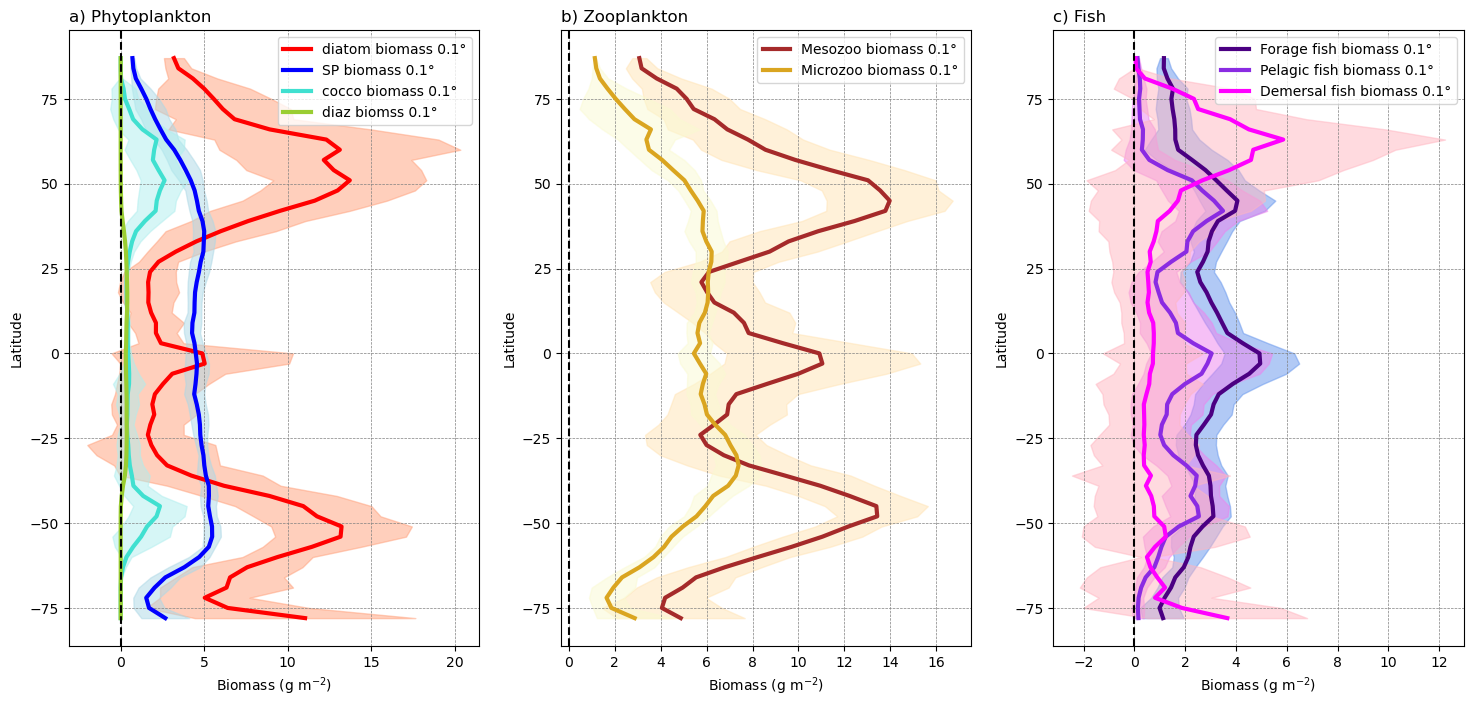

In [55]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) Phytoplankton', loc='left')
ax.plot(ds_zonal_x01.diatC, ds_zonal_x01.lat, label='diatom biomass 0.1°', linewidth=3, color='red')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.diatC-ds_zonal_x01_sd.diatC, ds_zonal_x01.diatC+ds_zonal_x01_sd.diatC,
                  color='lightsalmon',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.spC, ds_zonal_x01.lat, label='SP biomass 0.1°', linewidth=3, color='blue')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.spC-ds_zonal_x01_sd.spC, ds_zonal_x01.spC+ds_zonal_x01_sd.spC,
                  color='lightblue',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.coccoC, ds_zonal_x01.lat, label='cocco biomass 0.1°', linewidth=3, color='turquoise')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.coccoC-ds_zonal_x01_sd.coccoC, ds_zonal_x01.coccoC+ds_zonal_x01_sd.coccoC,
                  color='paleturquoise',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.diazC, ds_zonal_x01.lat, label='diaz biomss 0.1°', linewidth=3, color='yellowgreen')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.diazC-ds_zonal_x01_sd.diazC, ds_zonal_x01.diazC+ds_zonal_x01_sd.diazC,
                  color='honeydew',zorder=1,alpha=0.5)

# ax.plot(ds_zonal_x1.photoC_diat_zint*0.01*86400, ds_zonal_x1.lat, label='diatom NPP x1', linewidth=1, color='red')
# ax.plot(ds_zonal_x1.photoC_sp_zint*0.01*86400, ds_zonal_x1.lat, label='SP NPP x1', linewidth=1, color='blue')
# ax.plot(ds_zonal_x1.photoC_cocco_zint*0.01*86400, ds_zonal_x1.lat, label='cocco NPP x1', linewidth=1, color='turquoise')
# ax.plot(ds_zonal_x1.photoC_diaz_zint*0.01*86400, ds_zonal_x1.lat, label='diaz NPP x1', linewidth=1, color='yellowgreen')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,2)
ax.set_title('b) Zooplankton', loc='left')
ax.plot(ds_zonal_x01.mesozooC, ds_zonal_x01.lat, label='Mesozoo biomass 0.1°', linewidth=3, color='brown')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.mesozooC-ds_zonal_x01_sd.mesozooC, ds_zonal_x01.mesozooC+ds_zonal_x01_sd.mesozooC,
                  color='moccasin',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.microzooC, ds_zonal_x01.lat, label='Microzoo biomass 0.1°', linewidth=3, color='goldenrod')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.microzooC-ds_zonal_x01_sd.microzooC, ds_zonal_x01.microzooC+ds_zonal_x01_sd.microzooC,
                  color='lightgoldenrodyellow',zorder=1,alpha=0.5)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,3)
ax.set_title('c) Fish', loc='left')
ax.plot(ds_zonal_x01.forage_fish, ds_zonal_x01.lat, label='Forage fish biomass 0.1°', linewidth=3, color='indigo')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.forage_fish-ds_zonal_x01_sd.forage_fish, ds_zonal_x01.forage_fish+ds_zonal_x01_sd.forage_fish,
                  color='cornflowerblue',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.pelagic_fish, ds_zonal_x01.lat, label='Pelagic fish biomass 0.1°', linewidth=3, color='blueviolet')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.pelagic_fish-ds_zonal_x01_sd.pelagic_fish, ds_zonal_x01.pelagic_fish+ds_zonal_x01_sd.pelagic_fish,
                  color='violet',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.demersal_fish, ds_zonal_x01.lat, label='Demersal fish biomass 0.1°', linewidth=3, color='magenta')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.demersal_fish-ds_zonal_x01_sd.demersal_fish, ds_zonal_x01.demersal_fish+ds_zonal_x01_sd.demersal_fish,
                  color='lightpink',zorder=1,alpha=0.5)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')


fig.savefig('/glade/work/kristenk/figs/zonal_phytozoofish_prod.png', bbox_inches='tight', dpi=300, format='png');

### Make biomass figure

In [56]:
tot_fish_group_label_dict = {'forage':
                             {'data': tot_forage,
                              'label': "a) Total forage fish"},
                             'pelagic':
                             {'data': tot_pelagic,
                              'label': "b) Total large pelagic fish"},
                             'demersal':
                             {'data': tot_demersal,
                              'label': "c) Total demersal fish"},
                             'total':
                             {'data': tot_fish,
                              'label': "d) All fishes"}
                            }


In [57]:
tot_fish_group_label_dict.keys()

dict_keys(['forage', 'pelagic', 'demersal', 'total'])

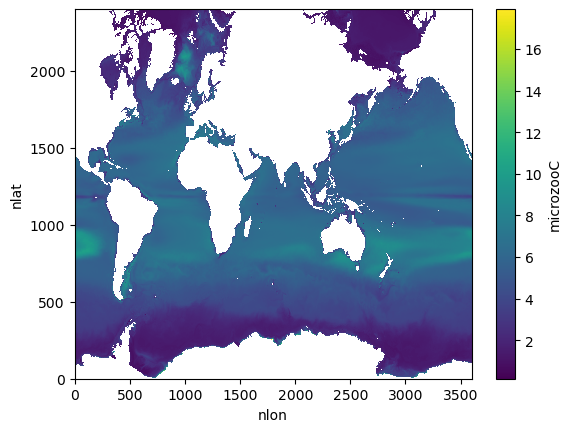

In [58]:
ds_fosi_mean.microzooC.plot()

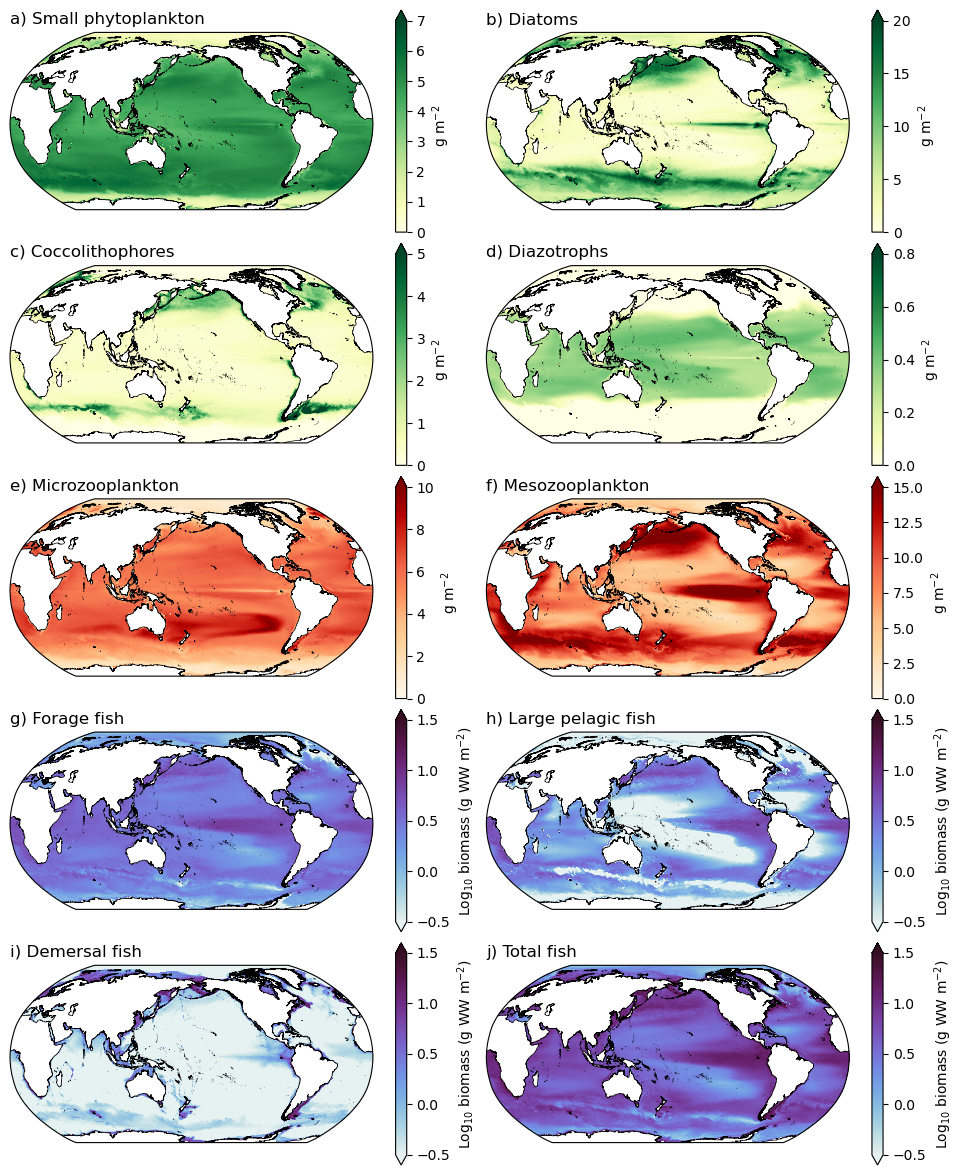

In [63]:
fig = plt.figure(figsize=(12,15))

################# phytoplankton
ax = fig.add_subplot(5,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Small phytoplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.spC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=7, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Diatoms', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.diatC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=20, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Coccolithophores', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.coccoC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=5, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Diazotrophs', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.diazC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.8, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

####################### zooplankton
ax = fig.add_subplot(5,2,5, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('e) Microzooplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.microzooC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=10, 
                 #cmap=cmocean.cm.amp,
                 cmap='OrRd',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,6, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('f) Mesozooplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.mesozooC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=15, 
                 #cmap=cmocean.cm.amp,
                 cmap='OrRd',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

####################### fish

ax = fig.add_subplot(5,2,7, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('g) Forage fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['forage']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
###########
ax = fig.add_subplot(5,2,8, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('h) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['pelagic']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
###########
ax = fig.add_subplot(5,2,9, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('i) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['demersal']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
#########
ax = fig.add_subplot(5,2,10, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('j) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['total']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('/glade/work/kristenk/figs/all_biomass_glob_maps.png', bbox_inches='tight', dpi=300, format='png');

In [61]:
ds

<xarray.Dataset>
Dimensions:    (z_t: 62, nlat: 2400, nlon: 3600)
Dimensions without coordinates: z_t, nlat, nlon
Data variables:
    dz         (z_t) float32 1e+03 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04 2.5e+04
    KMT        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    spC        (nlat, nlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    diatC      (nlat, nlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    diazC      (nlat, nlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    coccoC     (nlat, nlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mesozooC   (nlat, nlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    microzooC  (nlat, nlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

AttributeError: 'Dataset' object has no attribute 'biomass'

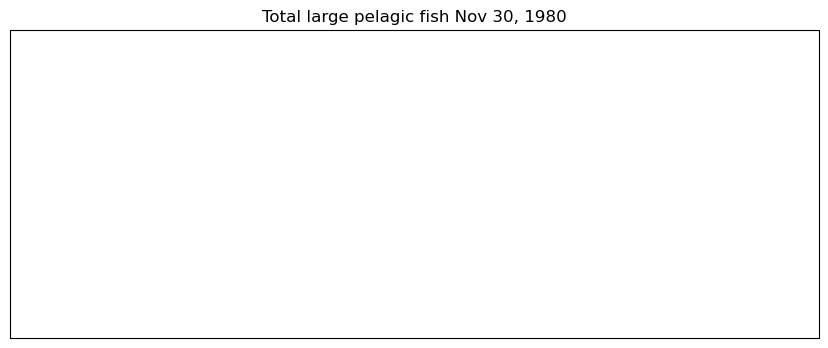

In [60]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -75, -20, 20], ccrs.PlateCarree())
ax.set_title("Total large pelagic fish Nov 30, 1980", loc='center')

time_index=334

tot_pelagic = ds.biomass.sel(group='Sp').isel(time=time_index) + ds.biomass.sel(group='Mp').isel(time=time_index) + ds.biomass.sel(group='Lp').isel(time=time_index)

lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_pelagic))

pc=ax.pcolormesh(lon, lat, field, vmin=-0.5, vmax=1.5, cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=10))
cs = ax.contour(lon,lat,field, colors='purple',
levels = [0.85],
linewidths = 1.5,
transform=ccrs.PlateCarree(),label='SIZ')


                                        
                                        
                                        
cbar1 = fig.colorbar(pc, extend='both',label='Demersal fish, log$_{10}$ biomass (g m$^{-2}$)')

#plt.savefig('feisty_hires_demersal_Nov30_antarctic.png', dpi=300)

plt.show()



In [ ]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -75, -20, 20], ccrs.PlateCarree())
ax.set_title("Total large large pelagic fish, Feb 20, 1980", loc='left')

time_index=50

tot_pelagic = ds.biomass.sel(group='Sp').isel(time=time_index) + ds.biomass.sel(group='Mp').isel(time=time_index) + ds.biomass.sel(group='Lp').isel(time=time_index)

lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds.biomass.sel(group='Lp').isel(time=time_index)))

pc=ax.pcolormesh(lon, lat, field, vmin=-0.5, vmax=1, cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=10))
cs = ax.contour(lon,lat,field, colors='purple',
levels = [0.85],
linewidths = 1.5,
transform=ccrs.PlateCarree(),label='SIZ')


                                        
                                        
                                        
cbar1 = fig.colorbar(pc, extend='both',label='Demersal fish, log$_{10}$ biomass (g m$^{-2}$)')

plt.savefig('feisty_hires_LLpel_Feb20_EqPac.png', dpi=300)

plt.show()



In [ ]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -75, -20, 20], ccrs.PlateCarree())
ax.set_title("Total small large pelagic fish Nov 30, 1980", loc='left')

time_index=334

tot_pelagic = ds.biomass.sel(group='Sp').isel(time=time_index) + ds.biomass.sel(group='Mp').isel(time=time_index) + ds.biomass.sel(group='Lp').isel(time=time_index)

lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds.biomass.sel(group='Sp').isel(time=time_index)))

pc=ax.pcolormesh(lon, lat, field, vmin=-2, vmax=1.5, cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
                               
                                        
cbar1 = fig.colorbar(pc, extend='both',label='Small pelagic fish, log$_{10}$ biomass (g m$^{-2}$)')

plt.savefig('feisty_hires_SLpel_Nov30_EqPac.png', dpi=300)

plt.show()



In [ ]:
ds.biomass.sel(group='Sp').isel(time=time_index).plot()

In [ ]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/day_1'

In [ ]:
variables = ['mesozooC_zint_100m']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [ ]:
f'{path}/{case}.pop.h.{var}.19800102-19810101.nc'

In [ ]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.nday1.{var}.19800102-19810101.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True) #, preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

In [ ]:
ds_fosi_x01.mesozooC_zint_100m.isel(time=334).plot()

In [ ]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -75, -20, 20], ccrs.PlateCarree())
ax.set_title("Mesozooplankton biomass Feb 20, 1980", loc='left')

time_index=50 #feb 20

lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.mesozooC_zint_100m.isel(time=time_index)*0.01)

pc=ax.pcolormesh(lon, lat, field, vmin=20, vmax=200, cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

                                                                           
cbar1 = fig.colorbar(pc, extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$')

plt.savefig('mesozoo-biomass_Feb20_EqPac.png', dpi=300)

plt.show()

